# word2vec

### 3.1.3 신경망에서의 단어 처리

In [18]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])  # 입력
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)


[[-1.62918398 -0.02988301  0.32046485]]


In [21]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer= MatMul(W)
h = layer.forward(c)
print(h)

[[ 0.67039289 -0.17395553  0.56957421]]


### 3.2.1 CBOW 모델의 추론 처리

In [37]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul


# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)


[[-0.48820095 -2.0334375  -1.06022204 -1.17021187  2.13668868  1.47869206
   1.53532189]]


### 3.3.1 맥락과 타깃

In [40]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [50]:
def create_contexts_target(corpus: np.ndarray, window_size: int = 1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)
del create_contexts_target

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

In [58]:
import sys

sys.path.append("..")
from common.util import preprocess, create_contexts_target, convert_one_hot

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# print(vocab_size)
# print(target)
print(contexts)


[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


### 3.4 CBOW 모델 구현

In [62]:
import sys

sys.path.append("..")
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype("f")
        W_out = 0.01 * np.random.randn(H, V).astype("f")

        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)


### 3.4.1 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/root/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


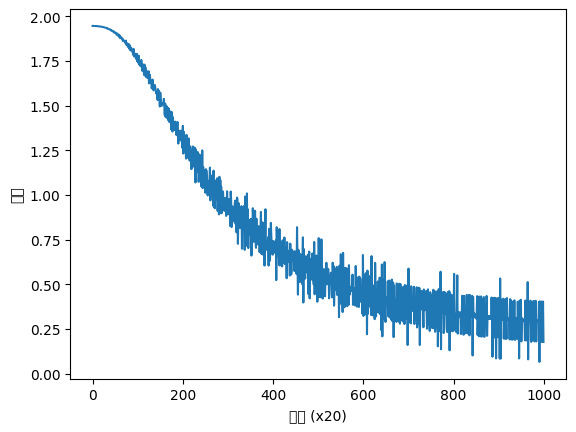

you [ 1.0641086  0.9627921  1.4494367  1.5074401 -1.2105579]
say [-0.73235625 -0.5161501   1.1153545   1.105164    1.4613179 ]
goodbye [ 0.86765987  1.0698936  -0.65848583 -0.80736345 -1.2057632 ]
and [-1.4940758  -1.6093376   0.93135864  0.8143398   0.4945556 ]
i [ 0.8745906  1.0648824 -0.6531125 -0.7715524 -1.2623158]
hello [ 1.0716317   0.94877887  1.4351138   1.5009435  -1.1906806 ]
. [1.5373703 1.5161986 1.0124307 1.0669446 1.5287586]


In [63]:
# coding: utf-8
import sys

sys.path.append("..")  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])
